In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn.functional as F
from tqdm import tqdm
from MIOFlow.models import GrowthRateModel

import os

data_name = 'growth_rate'
RAW_DATA_DIR = os.path.join('../../data', 'raw',data_name)
PROCESSED_DATA_DIR = os.path.join('../../data', 'processed',data_name)

print(PROCESSED_DATA_DIR)

../../data/processed/growth_rate


In [2]:

df0 = pd.read_csv(os.path.join(PROCESSED_DATA_DIR,'dying_example_growth_rate.csv'))

scaler = StandardScaler()
df0[['d1', 'd2']] = scaler.fit_transform(df0[['d1', 'd2']])
df0.head()

,d1,d2,samples,growth_rate
0,-0.928599,0.411794,0,1.153308
1,-0.951582,-1.774723,0,1.107995
2,-0.871550,-0.473042,0,1.156028
3,-1.018582,-0.253726,0,1.076405
4,-1.590069,-0.248106,0,0.761930


In [3]:
df1 = df0[df0['samples']!=4]

In [16]:
df1.loc[df1['samples']!=3, 'growth_rate'].values

array([1.30105593, 1.24965769, 1.30414055, ..., 0.17271647, 0.88152556,
       0.03158799])

Epochs: 100%|██████████| 2000/2000 [00:23<00:00, 86.47it/s, loss=0.0297]


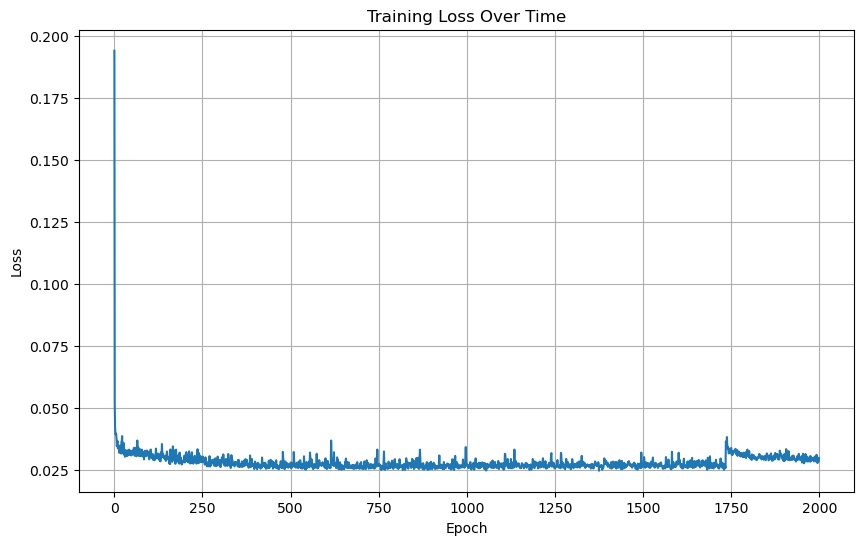

In [4]:
feature_dims = 2
condition_dims = 0
layers = [64, 32]
gmodel = GrowthRateModel(feature_dims, condition_dims, layers, use_time=False)
# train gmodel with sgd
data_x = torch.tensor(df1.loc[df1['samples']!=3, ['d1', 'd2']].values, dtype=torch.float32)
ys = df1.loc[df1['samples']!=3, 'growth_rate'].values
gscaler = MinMaxScaler(feature_range=(0, 2))
ys = gscaler.fit_transform(ys[:, np.newaxis])
data_y = torch.tensor(ys, dtype=torch.float32)
# optimizer = torch.optim.AdamW(gmodel.parameters(), lr=0.01, weight_decay=1e-2)  # Add weight_decay parameter
optimizer = torch.optim.AdamW(gmodel.parameters(), lr=0.01)  

# Create data loader
batch_size = 32
dataset = torch.utils.data.TensorDataset(data_x, data_y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# List to store losses
losses = []

progress_bar = tqdm(range(2000), desc='Epochs', position=0)
for epoch in progress_bar:
    epoch_loss = 0
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()
        pred = gmodel(batch_x)
        loss = F.mse_loss(pred, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    progress_bar.set_postfix({'loss': f'{avg_loss:.4f}'})

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

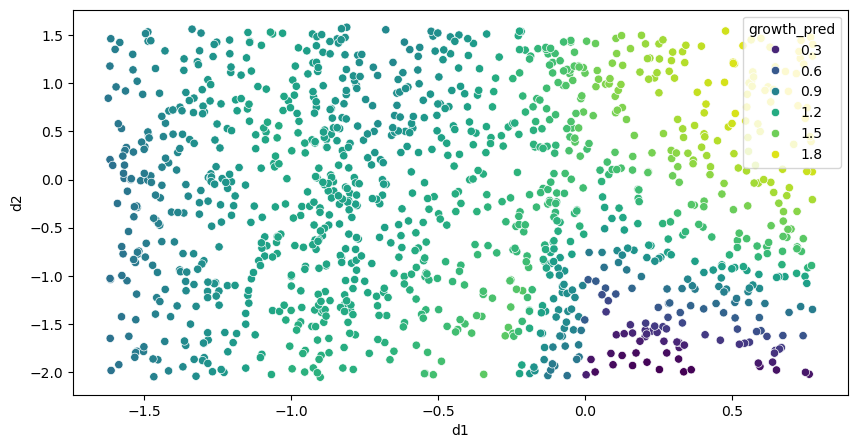

In [14]:
y_pred = gmodel(data_x).flatten().detach().numpy()
df2 = df1.copy()
df2['growth_pred'] = np.nan
df2.loc[df2['samples']!=3, 'growth_pred'] = y_pred
fig = plt.figure(figsize=(10, 5))
sns.scatterplot(data=df2, x='d1', y='d2', hue='growth_pred', palette='viridis');


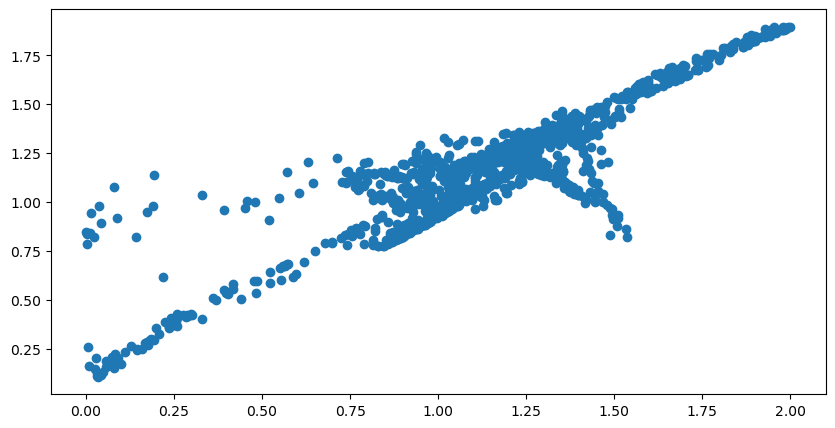

In [6]:
fig = plt.figure(figsize=(10, 5))
plt.scatter(data_y, y_pred);

In [7]:
# Save the trained model
torch.save(gmodel, os.path.join(PROCESSED_DATA_DIR,'gmodel_full4.pt'))  # Save complete model
torch.save(gmodel.state_dict(), os.path.join(PROCESSED_DATA_DIR,'gmodel_state4.pt'))  # Save model state dict

In [8]:
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler(feature_range=(0, 2))
df1['growth_rate'] = minmaxscaler.fit_transform(df1[['growth_rate']])

/var/folders/1r/l8_zwkvx7_g7b632hf_1517c0000gn/T/ipykernel_8998/2945525973.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['growth_rate'] = minmaxscaler.fit_transform(df1[['growth_rate']])


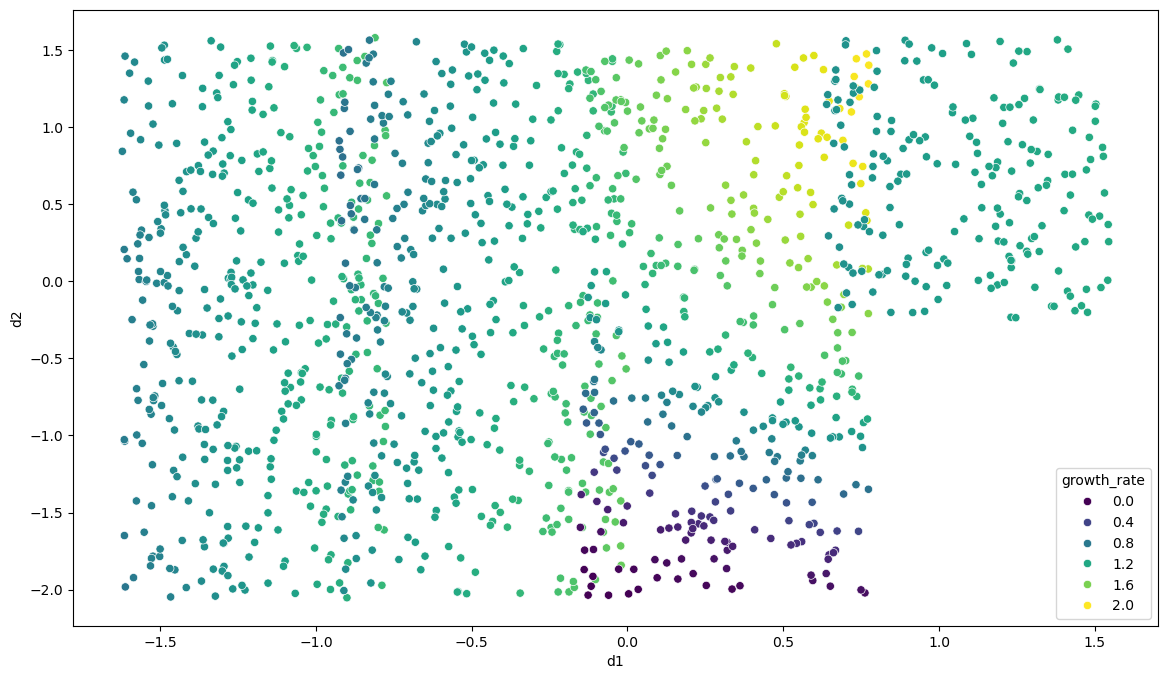

In [9]:
fig = plt.figure(figsize=(14, 8))
sns.scatterplot(data=df1, x='d1', y='d2', hue='growth_rate', palette='viridis');

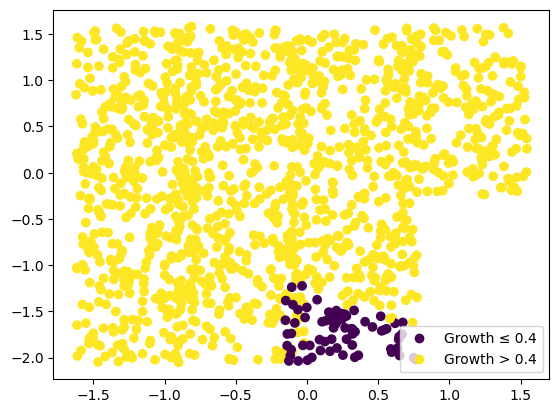

In [10]:
threshold = 0.4
scatter = plt.scatter(df1['d1'], df1['d2'], c=df1['growth_rate']>threshold)
plt.legend(scatter.legend_elements()[0], [f'Growth ≤ {threshold}', f'Growth > {threshold}'])


In [11]:
df1.to_csv(os.path.join(PROCESSED_DATA_DIR,"growth_rate_sample.csv"))

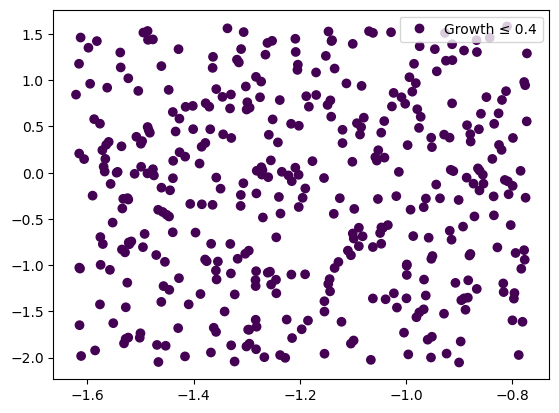

In [12]:
threshold = 0.4
scatter = plt.scatter(df1[df1['samples'] == 0]['d1'], df1[df1['samples'] == 0]['d2'], c=df1[df1['samples'] == 0]['growth_rate']>threshold, alpha=1)
plt.legend(scatter.legend_elements()[0], [f'Growth ≤ {threshold}', f'Growth > {threshold}'])


<Axes: >

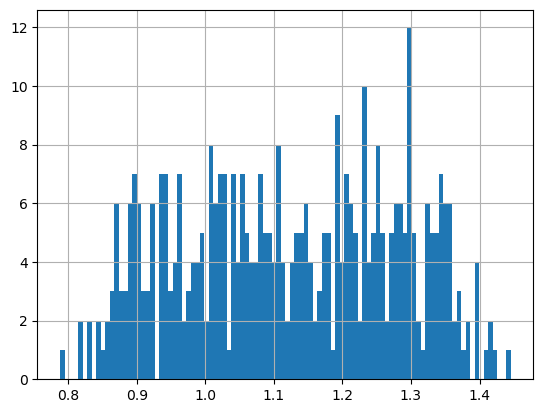

In [13]:
df1[df1['samples'] == 0]['growth_rate'].hist(bins=100)